In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline


In [2]:
#peak into data 
data = pd.read_csv('un-general-debates.csv')
print (data[0:10])


   session  year country                                               text
0       44  1989     MDV  ﻿It is indeed a pleasure for me and the member...
1       44  1989     FIN  ﻿\nMay I begin by congratulating you. Sir, on ...
2       44  1989     NER  ﻿\nMr. President, it is a particular pleasure ...
3       44  1989     URY  ﻿\nDuring the debate at the fortieth session o...
4       44  1989     ZWE  ﻿I should like at the outset to express my del...
5       44  1989     PHL  ﻿Before you began to occupy that exalted seat,...
6       44  1989     SDN  ﻿It gives me great pleasure to congratulate Am...
7       44  1989     RUS  ﻿My task as head of the delegation of the Sovi...
8       44  1989     CHN  ﻿\nPermit me to begin by warmly congratulating...
9       44  1989     ESP  ﻿I should like to express my sincere congratul...


In [3]:
# reading column 'text'
pd.read_csv('un-general-debates.csv')['text']

0       ﻿It is indeed a pleasure for me and the member...
1       ﻿\nMay I begin by congratulating you. Sir, on ...
2       ﻿\nMr. President, it is a particular pleasure ...
3       ﻿\nDuring the debate at the fortieth session o...
4       ﻿I should like at the outset to express my del...
5       ﻿Before you began to occupy that exalted seat,...
6       ﻿It gives me great pleasure to congratulate Am...
7       ﻿My task as head of the delegation of the Sovi...
8       ﻿\nPermit me to begin by warmly congratulating...
9       ﻿I should like to express my sincere congratul...
10      ﻿\n \n\nLike many other countries in the devel...
11      ﻿\n\n \n\nI should like to begin by congratula...
12      ﻿\n\nI should like first to express our most s...
13      ﻿Allow me at the outset to congratulate you, S...
14      ﻿\nI have the honour to convey to you, Sir and...
15      ﻿\nAllow me to congratulate you, Sir, on your ...
16      ﻿\nOn behalf of the people and the Government ...
17      ﻿Pleas

In [4]:
#cleaning data by :  replacing uppercase with lower case

data['text'] = data['text'].str.lower()
print(data[1:10])


   session  year country                                               text
1       44  1989     FIN  ﻿\nmay i begin by congratulating you. sir, on ...
2       44  1989     NER  ﻿\nmr. president, it is a particular pleasure ...
3       44  1989     URY  ﻿\nduring the debate at the fortieth session o...
4       44  1989     ZWE  ﻿i should like at the outset to express my del...
5       44  1989     PHL  ﻿before you began to occupy that exalted seat,...
6       44  1989     SDN  ﻿it gives me great pleasure to congratulate am...
7       44  1989     RUS  ﻿my task as head of the delegation of the sovi...
8       44  1989     CHN  ﻿\npermit me to begin by warmly congratulating...
9       44  1989     ESP  ﻿i should like to express my sincere congratul...


In [5]:
# metadata of country dialogue
data['char_count'] = data['text'].str.len()
data['words'] = data['text'].str.split(' ')
data['sentences'] = data['text'].str.split('.')
data['word_count'] = data['words'].str.len()
data['sentence_count'] = data['sentences'].str.len()
data['word_length'] = data['char_count'] / data['word_count']
data['sentence_length'] = data['word_count'] / data['sentence_count']

print('avg char count:', data['char_count'].mean())
print()
print('avg word count:', data['word_count'].mean())
print('avg word length:', data['word_length'].mean())
print()
print('avg sentence count:', data['sentence_count'].mean())
print('avg sentence len:', data['sentence_length'].mean())

avg char count: 17967.281603836418

avg word count: 2741.6649793526044
avg word length: 6.6270478190283395

avg sentence count: 119.77447715465566
avg sentence len: 23.510892064306564


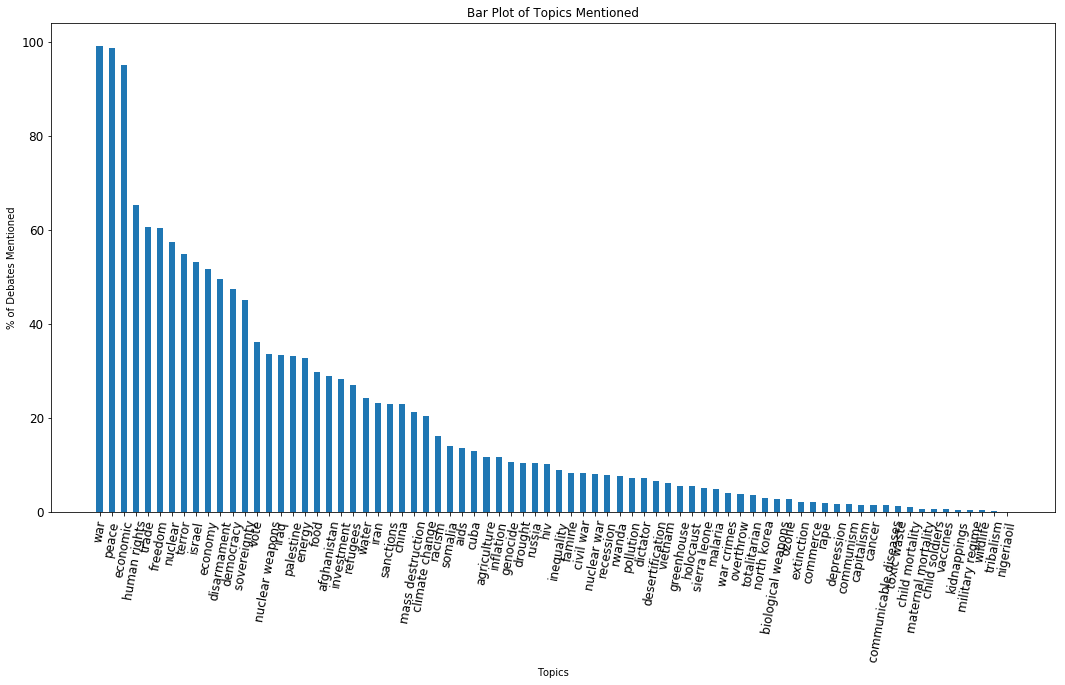

In [6]:
#  a dictionary of possible tobics disccussed during the general debates
#topics are arranged in the following groups (in ascending order):
#                     1.Commerce and trade
#                     2.Environment
#                     3.Disarmamnet
#                     4.Health 
#                     5.Human rights
#                     6.Humanitarain affairs.
#                     7.Peace and security 
#                     8.Governments and their structures
#                     9. Countries of interest based on historical events
#                     10. Countries' special interest

# source:https://research.un.org/en/un-resources/topic 
topics = ['commerce', 'trade','economy', 'economic','investment', 'energy','inflation', 
          'recession','sanctions','child soldiers', 'tribalism',
          'greenhouse',  'pollution', 'climate change',
           'agriculture', 'water',  'desertification', 
           'drought', 'famine', 'extinction', 'wildlife', 'toxic waste', 
          'ozone', 'agriculture', 'food','disarmament',  
          'aids', 'hiv', 'malaria', 
           'maternal mortality',  'child mortality', 
           'communicable diseases',
          'cancer', 'depression', 
           'vaccines', 'communism', 'capitalism',
           'human rights', 'inequality', 
             'tribalism',
           'racism', 'refugees', 
           'nuclear weapons', 'biological weapons', 
          'nuclear', 'mass destruction', 'peace', 'war','nuclear war', 'war crimes', 
          'civil war', 'rape',  'child soldiers', 'nigeria' 'oil',
          'kidnappings', 'terror', 'genocide', 'holocaust','democracy', 'freedom', 
          ' sovereignty', 'dictator', 'totalitarian', 'vote', 'military regime',
          'overthrow','afghanistan', 
          'russia', 'iran', 'china', 'palestine', 'israel', 'north korea', 
          'somalia', 'sierra leone', 'rwanda','iraq', 'cuba', 'vietnam']
dictionary = {}

for i in topics:    
    dictionary[i] = data['year'][data['text'].str.contains(i)].count() / len(data) * 100

sorted_dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)

labels = [i[0] for i in sorted_dictionary]
values = [i[1] for i in sorted_dictionary]
xs = np.arange(len(labels))

width = .50
plt.figure(figsize=(18, 9))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=80)
plt.xlabel('Topics')
plt.ylabel('% of Debates Mentioned')
plt.title('Bar Plot of Topics Mentioned')

plt.bar(xs, values, width, align='center')
plt.xticks(xs, labels)
plt.show()

In [7]:
# Plot a horizontal bar graph displaying the frequency of a given topic by country
def freqMentioned (df, country_list, topic_list, colors):
    data = df.loc[df['country'].isin(country_list)]

    for i in topic_list:
        data[i] = data['text'].str.contains(i)
        data[i].loc[data[i] == False] = np.nan

    country = country_list[0]
    data_out = pd.DataFrame(data.loc[data['country'] == country].count())
    data_out = (data_out.T)[topic_list]
    
    # sort the columns by summed occurence in countries specified
    countries = country_list.copy()
    countries.remove(country)

    for i in countries:
        a = pd.DataFrame(data.loc[data['country'] == i].count())
        a = (a.T)[topic_list].copy()
        data_out = pd.concat([data_out, a], axis=0)

    dictionary = {}
    
    for i in topic_list:
        dictionary[i] = data_out[i].sum()
        
    sorted_dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
    data_out = data_out[[i[0] for i in sorted_dictionary]]
    data_out.index = country_list
    data_out.T.plot(kind="barh", width=.6, stacked=True, figsize = (10, len(topic_list)/3), color=colors).legend(bbox_to_anchor=(1, 1))
    
    return data_out


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,war,peace,economic,trade,israel,freedom,human rights,economy,disarmament,terror,...,depression,greenhouse,north korea,ozone,totalitarian,communism,cancer,biological weapons,capitalism,communicable diseases
KEN,45,45,45,39,25,24,26,29,24,23,...,1,0,2,0,0,0,1,0,0,0
UGA,41,38,39,32,25,24,25,24,21,15,...,3,1,0,0,0,1,0,0,1,0
TZA,45,45,42,35,37,28,22,21,24,20,...,0,1,0,1,0,0,0,1,0,0
SDN,46,46,46,27,41,33,34,24,20,27,...,1,0,0,2,0,0,1,1,0,0
RWA,46,44,44,29,24,28,26,21,23,18,...,0,1,1,1,2,0,0,0,0,0
BDI,45,45,45,29,20,26,24,23,27,29,...,0,1,1,0,1,2,1,0,0,0


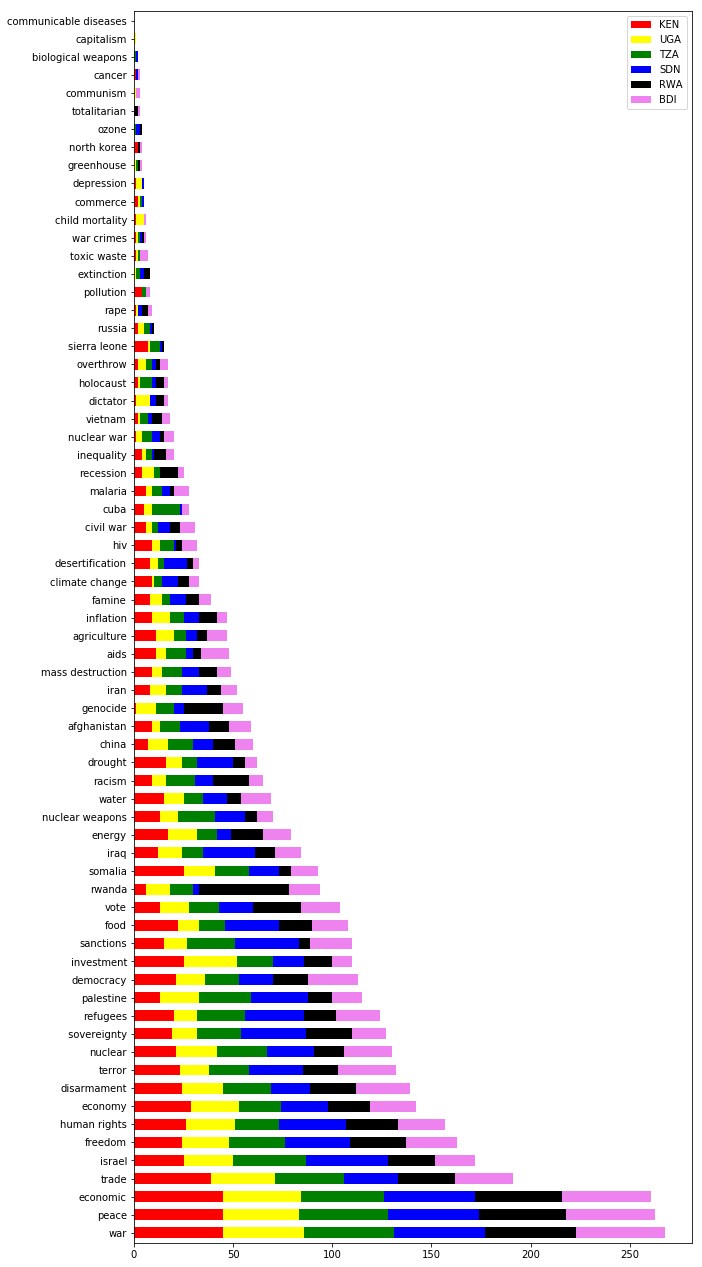

In [8]:
#East Africa Community- also member states of 
country = ['KEN','UGA', 'TZA', 'SDN', 'RWA', 'BDI']

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'violet']
freqMentioned(data, country, topics, colors)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,war,peace,economic,trade,israel,human rights,freedom,economy,terror,nuclear,...,ozone,north korea,biological weapons,totalitarian,child mortality,depression,communism,capitalism,cancer,communicable diseases
KEN,45,45,45,39,25,26,24,29,23,21,...,0,2,0,0,1,1,0,0,1,0
UGA,41,38,39,32,25,25,24,24,15,21,...,0,0,0,0,4,3,1,1,0,0
SDN,46,46,46,27,41,34,33,24,27,24,...,2,0,1,0,0,1,0,0,1,0
ETH,45,45,45,28,15,21,23,24,26,22,...,0,0,2,0,0,1,0,1,0,0
RWA,46,44,44,29,24,26,28,21,18,15,...,1,1,0,2,0,0,0,0,0,0
BDI,45,45,45,29,20,24,26,23,29,24,...,0,1,0,1,1,0,2,0,1,0
ERI,22,23,20,4,4,10,5,8,13,1,...,0,0,0,0,0,0,0,0,0,0
DJI,29,29,28,17,27,19,21,20,15,9,...,0,1,0,1,0,0,1,0,0,1
COD,44,44,39,23,24,21,28,21,18,22,...,3,0,0,1,0,0,0,2,0,0
MDG,42,42,42,24,18,26,24,23,22,25,...,1,1,1,3,0,0,0,1,0,0


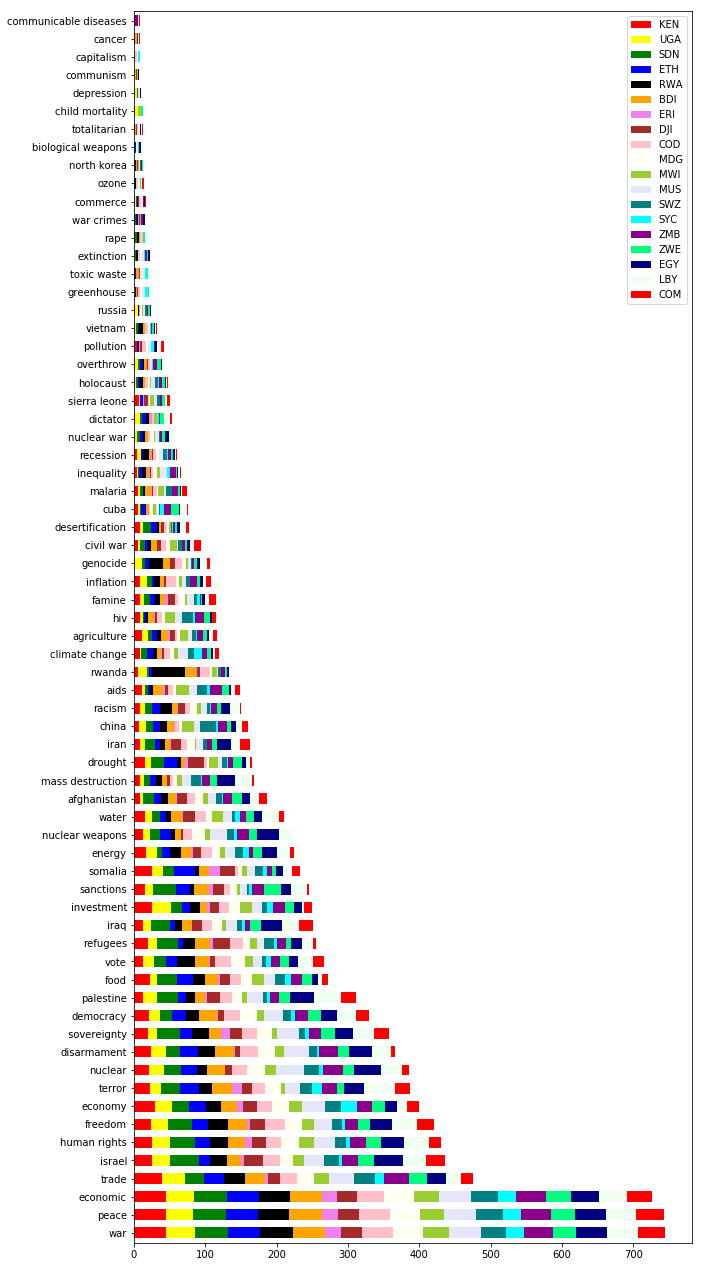

In [9]:
#Common Market for Eastern and Southern Africa (COMESA) memeber countries
country = ['KEN','UGA', 'SDN','ETH', 'RWA', "BDI", 'ERI', 'DJI', 'COD',
          'MDG', 'MWI', 'MUS', 'SWZ', 'SYC', 'ZMB', 'ZWE', 'EGY', 'LBY', 'COM' ]

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet','brown', 
          'pink', 'ivory','yellowgreen', 'lavender', 'teal', 'aqua','darkmagenta',
         'springgreen','navy', 'honeydew']
freqMentioned(data, country, topics, colors)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,peace,war,economic,freedom,trade,human rights,terror,economy,sovereignty,israel,...,north korea,depression,toxic waste,child mortality,biological weapons,commerce,communism,communicable diseases,capitalism,cancer
AGO,38,36,38,21,26,22,22,21,25,29,...,1,1,1,0,0,1,0,0,0,0
BRD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CMR,41,41,38,25,29,23,22,20,21,19,...,2,1,2,0,0,0,0,0,0,0
CAF,42,42,38,24,22,29,19,23,18,12,...,0,0,0,1,1,0,1,0,0,0
GNQ,39,38,39,31,21,34,24,16,20,15,...,1,0,0,0,1,0,0,1,0,0
RWA,44,46,44,28,29,26,18,21,23,24,...,1,0,0,0,0,0,0,0,0,0
STP,30,30,31,20,21,12,19,19,13,18,...,0,1,0,2,0,1,0,0,0,0


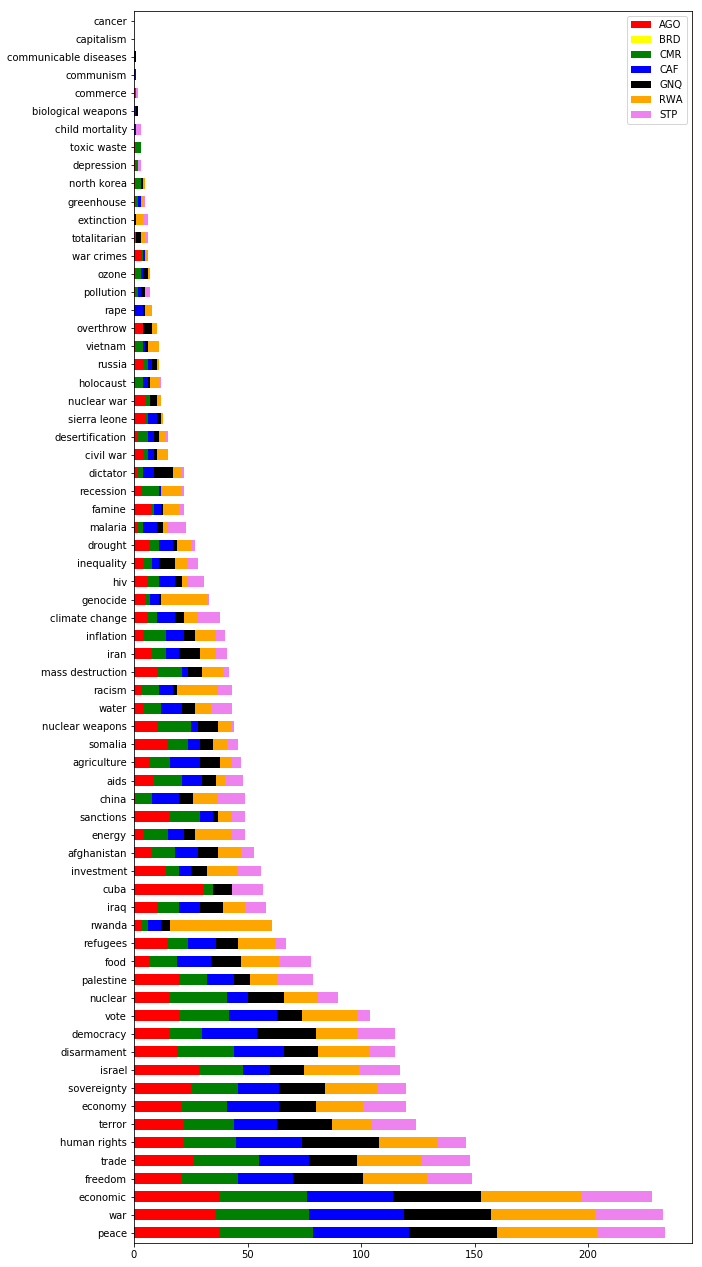

In [10]:
#The Economic Community of Central African States- ECCAS
country = ['AGO','BRD', 'CMR','CAF','GNQ','RWA','STP']

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet']
freqMentioned(data, country, topics, colors)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,peace,economic,war,trade,human rights,freedom,israel,economy,disarmament,democracy,...,biological weapons,extinction,commerce,capitalism,depression,cancer,child mortality,totalitarian,communism,communicable diseases
BEN,43,43,43,31,27,28,27,23,23,25,...,0,0,0,1,1,1,0,0,0,0
BFA,44,44,41,30,27,28,30,27,22,25,...,0,0,0,2,0,0,0,0,0,0
CPV,38,38,38,15,27,19,11,21,16,21,...,0,0,1,0,0,0,0,0,0,1
CIV,33,33,33,22,20,15,14,19,18,16,...,0,0,0,0,1,0,0,0,0,0
GMB,38,37,38,34,29,25,27,22,12,26,...,0,2,0,0,0,0,1,1,0,0
GHA,45,45,46,37,31,25,24,26,27,18,...,3,2,0,0,0,1,1,0,1,1
GIN,45,45,45,31,34,34,37,23,34,24,...,1,0,0,3,0,0,0,1,0,0
GNB,38,38,38,19,23,23,23,22,14,24,...,0,2,1,0,1,0,0,0,0,0
LBR,45,45,44,29,33,34,25,24,29,23,...,1,2,1,2,1,0,1,1,0,0
MLI,43,43,43,29,28,28,30,26,29,23,...,1,0,2,1,0,2,0,0,1,1


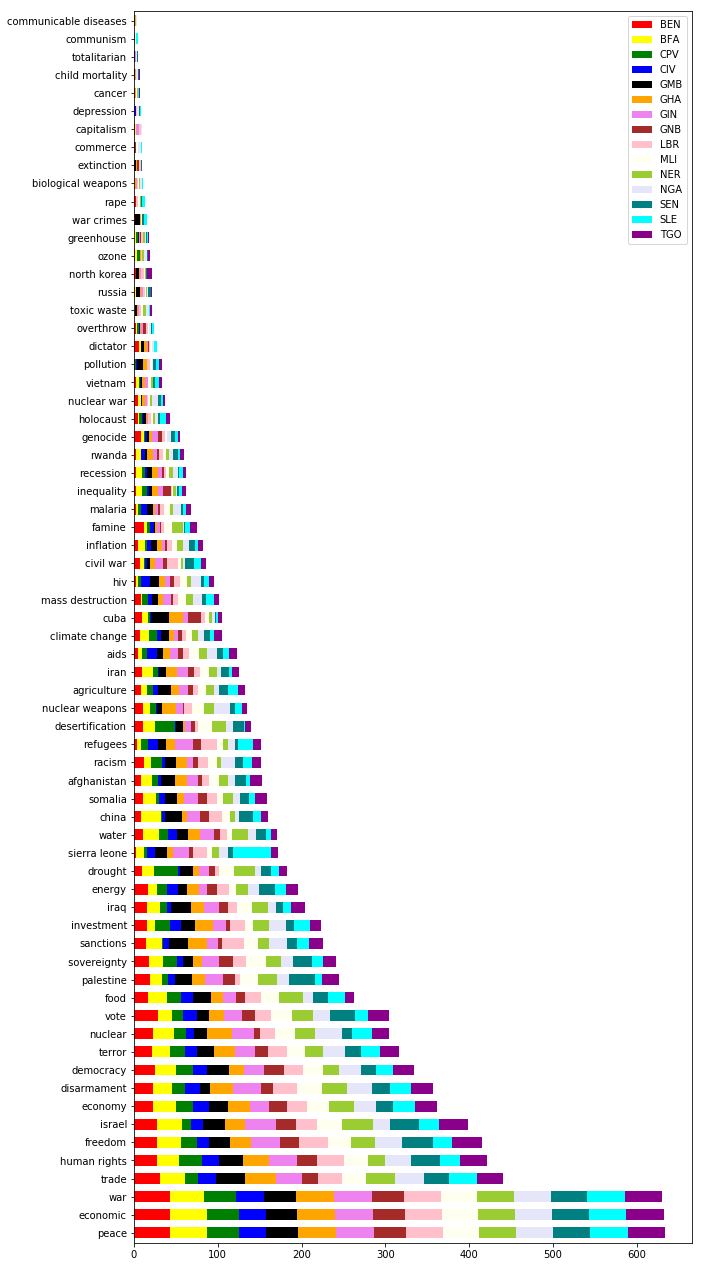

In [11]:
#Economic Community of West African- ECOWAS member States
country = ['BEN', 'BFA', 'CPV', 'CIV', 'GMB', 'GHA', 'GIN', 'GNB', 'LBR', 'MLI', 
          'NER', 'NGA', 'SEN', 'SLE', 'TGO']

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet','brown', 
          'pink', 'ivory','yellowgreen', 'lavender', 'teal', 'aqua','darkmagenta']
freqMentioned(data, country, topics, colors)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,peace,war,economic,trade,israel,human rights,freedom,economy,nuclear,disarmament,...,child mortality,biological weapons,rape,capitalism,north korea,totalitarian,communicable diseases,depression,communism,cancer
AGO,38,36,38,26,29,22,21,21,16,19,...,0,0,0,0,1,1,0,1,0,0
BWA,40,40,40,27,28,29,22,15,15,12,...,1,1,0,0,0,1,0,0,0,0
COD,44,44,39,23,24,21,28,21,22,26,...,0,0,4,2,0,1,0,0,0,0
LSO,41,41,41,25,25,25,25,13,29,22,...,1,3,1,0,0,0,0,1,0,0
MDG,42,42,42,24,18,26,24,23,25,24,...,0,1,0,1,1,3,0,0,0,0
MWI,34,36,35,22,15,21,17,18,15,12,...,4,0,0,1,1,1,0,0,2,1
MUS,45,45,45,35,29,29,25,33,40,35,...,0,1,0,0,2,0,0,2,0,0
MOZ,40,40,40,28,24,18,28,29,17,19,...,1,0,2,3,0,0,0,0,1,0
NAM,26,25,26,17,15,16,16,14,10,7,...,1,0,0,0,0,0,1,0,0,0
SYC,26,25,26,13,5,6,5,22,6,3,...,0,0,0,2,0,0,0,0,0,0


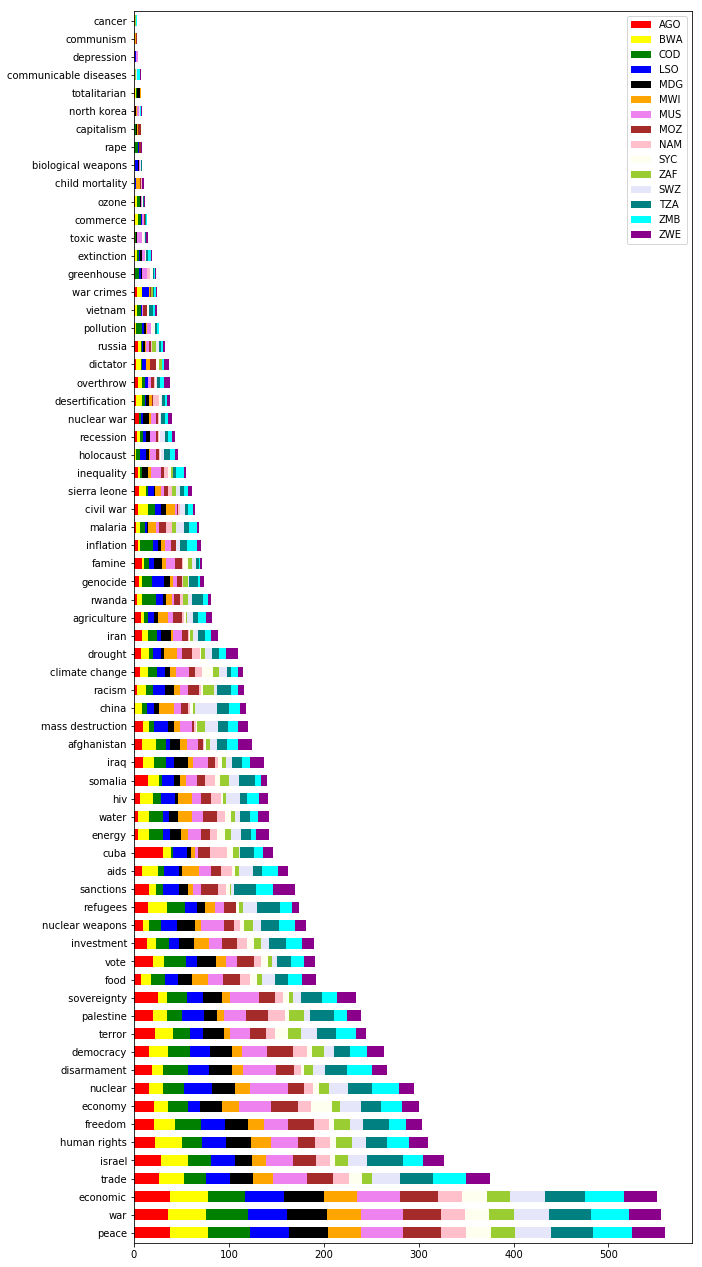

In [12]:
#Southern Africa Coordination Conference -SADCC member states
country = ['AGO', 'BWA', 'COD', 'LSO','MDG', 'MWI', 'MUS','MOZ', 'NAM', 'SYC', 'ZAF',
          'SWZ', 'TZA', 'ZMB', 'ZWE' ]

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet','brown', 
          'pink', 'ivory','yellowgreen', 'lavender', 'teal', 'aqua','darkmagenta']
freqMentioned(data, country, topics, colors)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,war,peace,economic,trade,human rights,israel,somalia,freedom,economy,terror,...,child mortality,biological weapons,greenhouse,extinction,cancer,ozone,communism,capitalism,totalitarian,communicable diseases
KEN,45,45,45,39,26,25,25,24,29,23,...,1,0,0,0,1,0,0,0,0,0
SDN,46,46,46,27,34,41,15,33,24,27,...,0,1,0,2,1,2,0,0,0,0
ETH,45,45,45,28,21,15,29,23,24,26,...,0,2,1,0,0,0,0,1,0,0
ERI,22,23,20,4,10,4,15,5,8,13,...,0,0,0,0,0,0,0,0,0,0
DJI,29,29,28,17,19,27,22,21,20,15,...,0,0,1,0,0,0,1,0,1,1
SOM,36,36,35,22,23,23,34,21,15,22,...,0,1,0,0,1,0,0,0,0,0
SSD,5,5,4,1,3,0,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
UGA,41,38,39,32,25,25,16,24,24,15,...,4,0,1,1,0,0,1,1,0,0


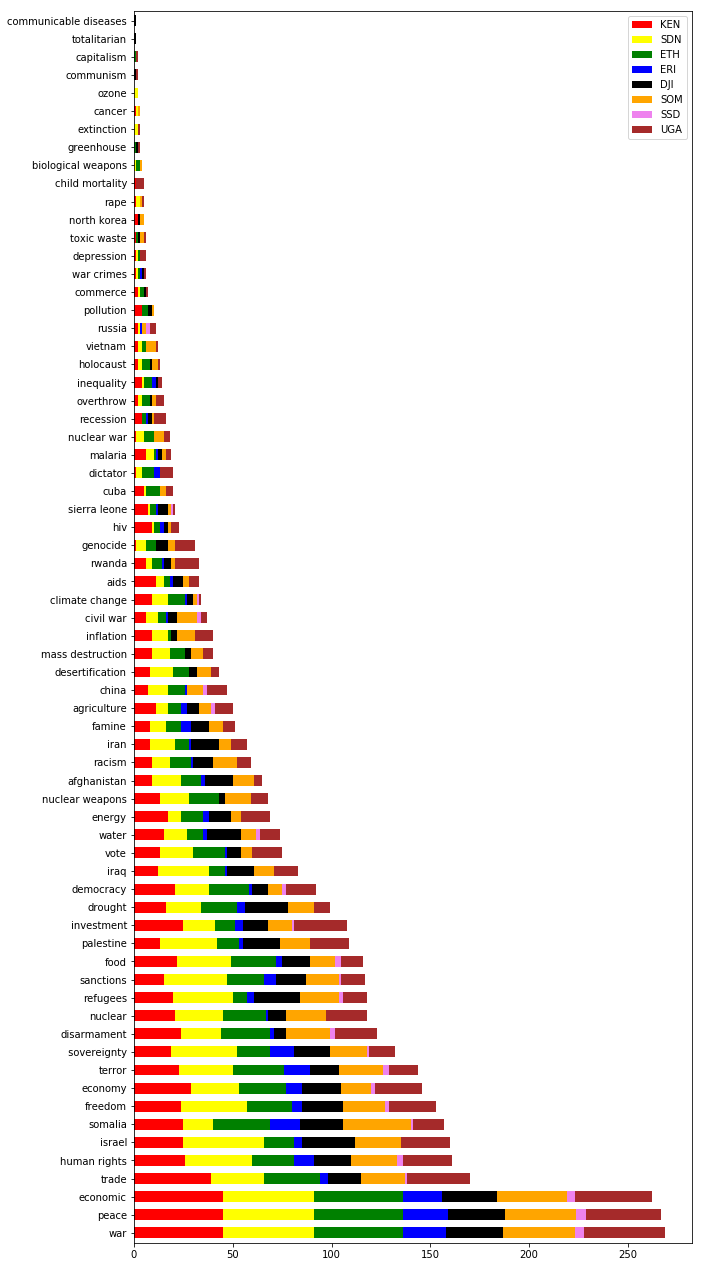

In [13]:
#Intergovernmental Authority on Development -IGAD memeber states
country = ['KEN', 'SDN','ETH', 'ERI', 'DJI','SOM', 'SSD', 'UGA']
topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet','brown']
freqMentioned(data, country, topics, colors)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,war,peace,economic,israel,freedom,palestine,terror,sovereignty,iraq,trade,...,extinction,commerce,war crimes,north korea,ozone,communism,capitalism,communicable diseases,depression,child mortality
DZA,45,46,45,32,29,30,28,34,27,27,...,0,0,0,1,0,0,0,0,0,0
LBY,44,42,39,33,35,38,43,30,24,22,...,0,1,2,0,1,1,1,1,0,0
MRT,45,45,45,41,38,30,25,24,28,26,...,1,1,0,0,0,0,0,1,0,0
MAR,45,45,45,41,25,24,24,38,24,28,...,2,0,0,0,0,0,0,0,1,0
TUN,46,46,45,41,31,25,23,17,31,25,...,0,1,0,1,1,1,1,0,0,0


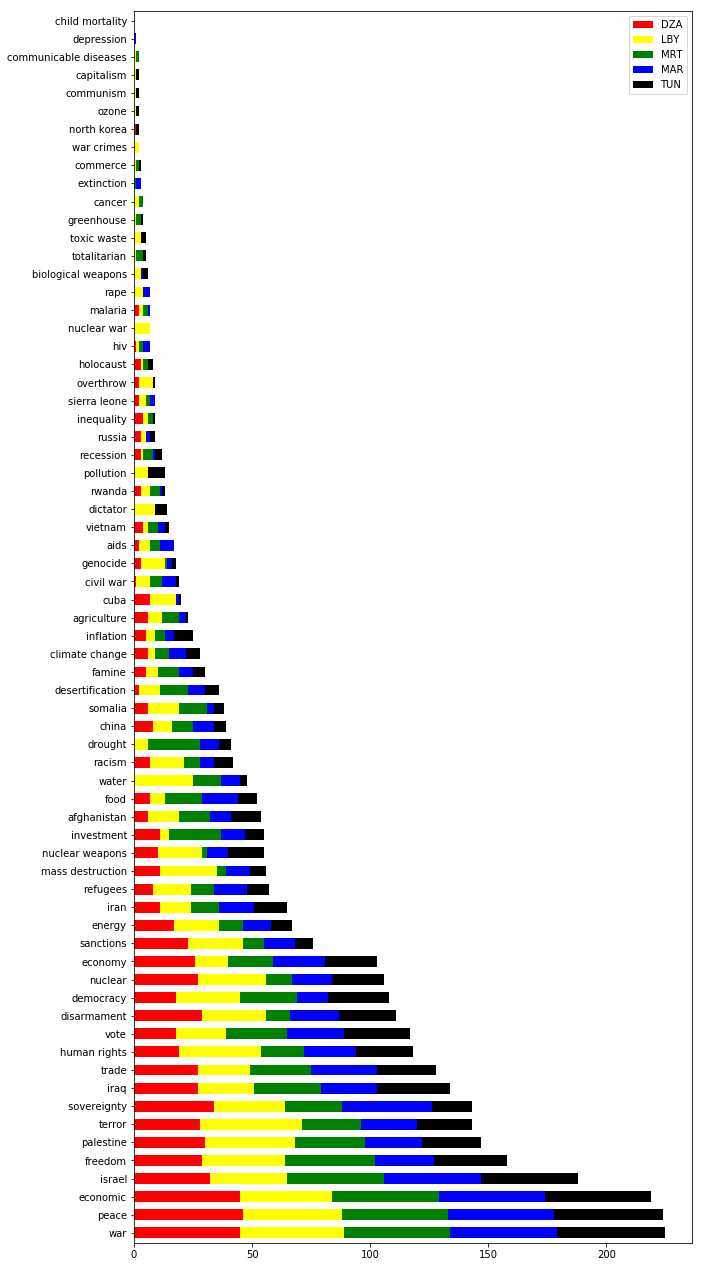

In [14]:
#The Arab Maghreb Union - AMU member states
country = ['DZA', 'LBY', 'MRT', 'MAR', 'TUN']
topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black']

freqMentioned(data, country, topics, colors)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,peace,war,economic,israel,freedom,trade,human rights,terror,economy,disarmament,...,greenhouse,extinction,commerce,cancer,depression,totalitarian,communism,capitalism,child mortality,communicable diseases
BEN,43,43,43,27,28,31,27,21,23,23,...,0,0,0,1,1,0,0,1,0,0
BFA,44,41,44,30,28,30,27,22,27,22,...,2,0,0,0,0,0,0,2,0,0
CAF,42,42,38,12,24,22,29,19,23,22,...,1,0,0,0,0,0,1,0,1,0
TCDCOM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CIV,33,33,33,14,15,22,20,14,19,18,...,1,0,0,0,1,0,0,0,0,0
DJI,29,29,28,27,21,17,19,15,20,6,...,1,0,1,0,0,1,1,0,0,1
EGY,43,43,40,41,31,26,33,28,17,32,...,0,3,1,0,2,1,1,0,0,0
ERI,23,22,20,4,5,4,10,13,8,2,...,0,0,0,0,0,0,0,0,0,0
GMB,38,38,37,27,25,34,29,20,22,12,...,0,2,0,0,0,1,0,0,1,0
GHA,45,46,45,24,25,37,31,25,26,27,...,1,2,0,1,0,0,1,0,1,1


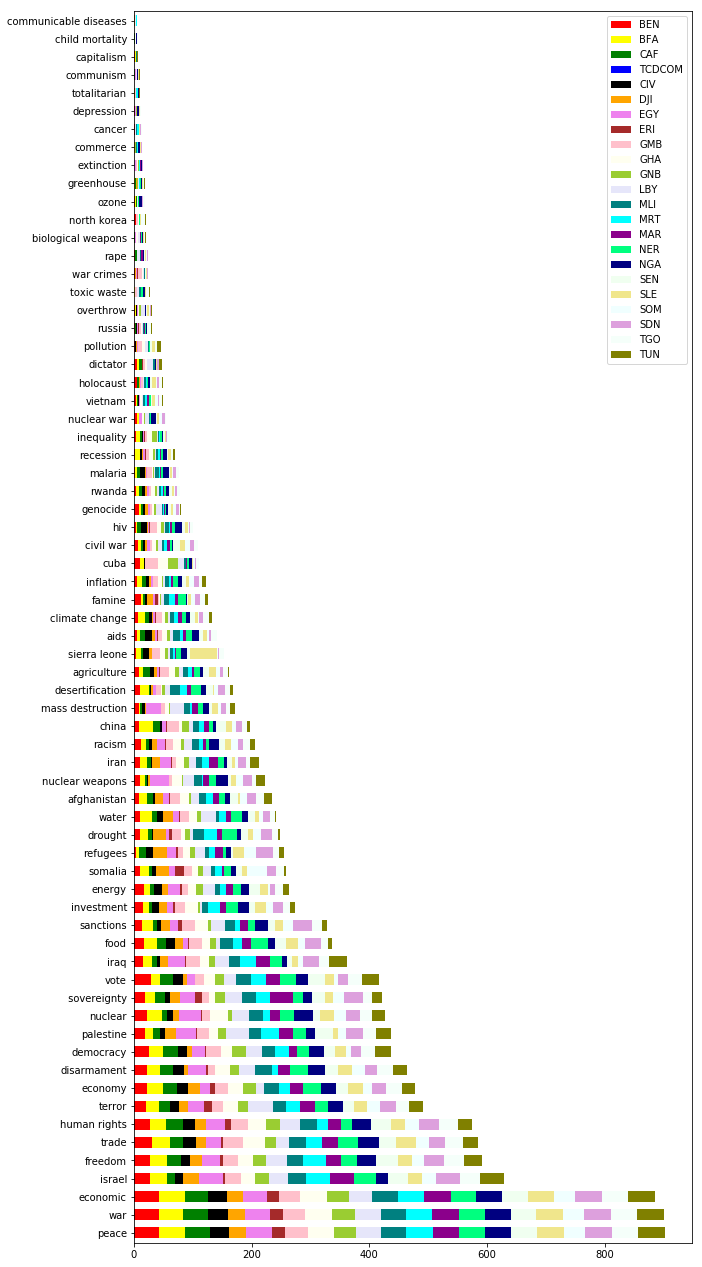

In [15]:
#Community of Sahel-Saharan States - CEN-SAD member states

country = ['BEN', 'BFA', 'CAF', 'TCD' 'COM', 'CIV', 'DJI', 'EGY', 'ERI', 'GMB', 
           'GHA', 'GNB', 'LBY', 'MLI','MRT', 'MAR', 'NER', 'NGA', 'SEN','SLE', 'SOM',
           'SDN', 'TGO', 'TUN']

topics = []
for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

colors = ['red', 'yellow', 'green', 'blue', 'black', 'orange', 'violet','brown', 
          'pink', 'ivory','yellowgreen', 'lavender', 'teal', 'aqua','darkmagenta',
         'springgreen','navy', 'honeydew', 'khaki', 'azure', 'plum', 'mintcream',
         'olive', 'peach']
freqMentioned(data, country, topics, colors)

In [16]:

topics = []

for i in sorted_dictionary:
    if i[1] > 1:
        topics.append(i[0])

def textFreq(df,country_list, topic_list):
    data = df.copy()
    data = df.loc[df['country'].isin(country_list)]
    for i in topic_list:
        data[i] = data['text'].apply(lambda x: x.count(i))
    #return data
    country = country_list[0]
    data_out = pd.DataFrame(data.loc[data['country'] == country].count())
    data_out = (data_out.T)[topic_list]
    countries = country_list.copy()
    countries.remove(country)
    for i in countries:
        a = pd.DataFrame(data.loc[data['country'] == i].count())
        a = (a.T)[topic_list].copy()
    return data
#topics = ['war', 'pollution'] 
#country =['ETH', 'KEN', 'RWA']
#textFreq(data,country, topics)

def groupFreq(df, country_list, topic_list, grouping_column):
    topic_freq = textFreq(df,country_list, topic_list)
    topic_list.append(grouping_column)
    topic_freq = topic_freq[topic_list]
    topic_freq_col = topic_freq.groupby(topic_freq[grouping_column]).sum()
    return topic_freq_col

#topic_freq_year = groupFreq(data, country, topics, 'year')



#topics = ['war', 'pollution'] 

           
           
country =['EGY', 'KEN', 'RWA'] 
topics =['economy', 'nuclear']
groupFreq(data, country, topics, 'year')


#topic_freq_year[['economy', 'nuclear']]




#topics = ['economy', 'nuclear']
#country =['ETH', 'KEN', 'RWA']
#textFreq(data,country, topics)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,economy,nuclear
year,,
1970,1,5
1971,2,4
1972,1,6
1973,1,0
1974,0,10
1975,0,1
1976,1,18
1977,2,16
1978,2,43


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


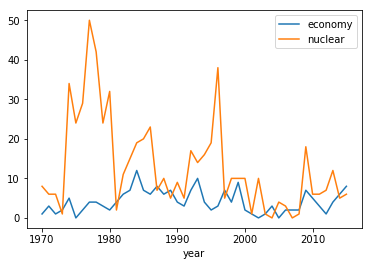

In [17]:
#test data
country =['USA', 'KEN', 'RWA'] 
topics =['economy', 'nuclear']
groupFreq(data, country, topics, 'year').plot()
#country =['ETH', 'KEN', 'RWA']
#topic_freq_year[['economy', 'rwanda']]
#topic_freq_year[['war', 'hiv']].plot()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


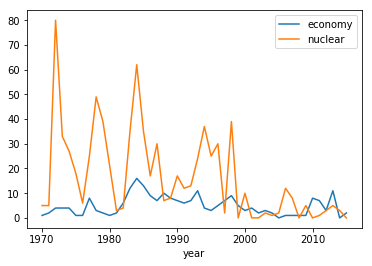

In [18]:

#test data
country =['CHN', 'KEN', 'RWA'] 
topics =['economy', 'nuclear']
groupFreq(data, country, topics, 'year').plot()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


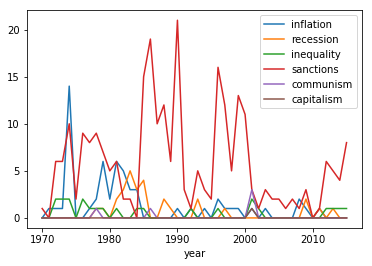

In [19]:
#East Africa Community- 
#Economic issues throughout the years
country = ['KEN','UGA', 'TZA', 'SDN', 'RWA', 'BDI']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


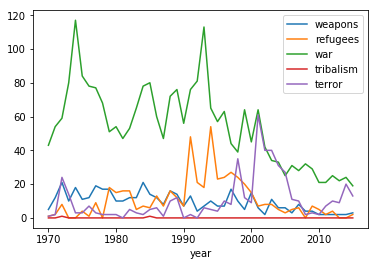

In [20]:
#East Africa Community
#Peace, stability and security issues
country = ['KEN','UGA', 'TZA', 'SDN', 'RWA', 'BDI']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


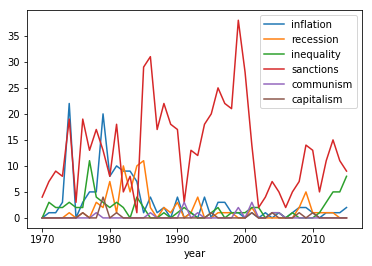

In [21]:
#Common Market for Eastern and Southern Africa (COMESA) memeber countries
#Economic issues throughout the years

country = ['KEN','UGA', 'SDN','ETH', 'RWA', "BDI", 'ERI', 'DJI', 'COD',
          'MDG', 'MWI', 'MUS', 'SWZ', 'SYC', 'ZMB', 'ZWE', 'EGY', 'LBY', 'COM' ]
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


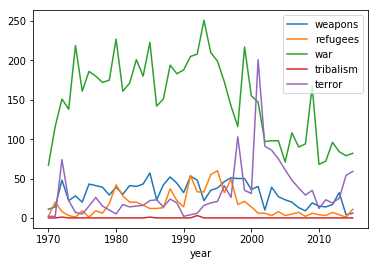

In [22]:
#Common Market for Eastern and Southern Africa (COMESA) memeber countries
#Peace, stability and security issues
country = ['KEN','UGA', 'SDN','ETH', 'RWA', "BDI", 'ERI', 'DJI', 'COD',
          'MDG', 'MWI', 'MUS', 'SWZ', 'SYC', 'ZMB', 'ZWE', 'EGY', 'LBY', 'COM' ]
topics =  topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


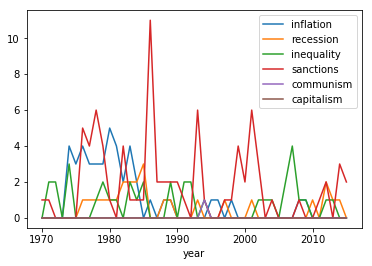

In [23]:
#The Economic Community of Central African States- ECCAS
#Economic issues throughout the years
country = ['AGO','BRD', 'CMR','CAF','GNQ','RWA','STP']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


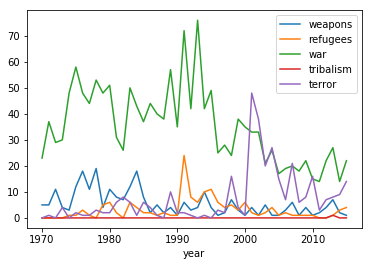

In [24]:
#The Economic Community of Central African States- ECCAS
#Peace, stability and security issues
country = ['AGO','BRD', 'CMR','CAF','GNQ','RWA','STP']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


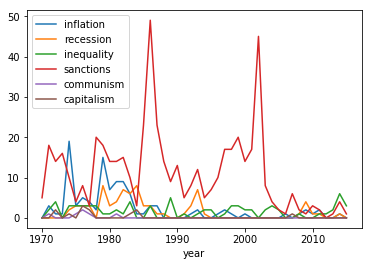

In [25]:
#Economic Community of West African- ECOWAS member States
#Economic issues throughout the years

country = ['BEN', 'BFA', 'CPV', 'CIV', 'GMB', 'GHA', 'GIN', 'GNB', 'LBR', 'MLI', 
          'NER', 'NGA', 'SEN', 'SLE', 'TGO']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


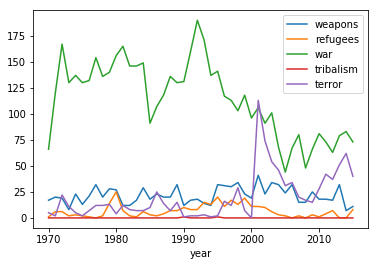

In [26]:
#Economic Community of West African- ECOWAS member States
#Peace, stability and security issues
country = ['BEN', 'BFA', 'CPV', 'CIV', 'GMB', 'GHA', 'GIN', 'GNB', 'LBR', 'MLI', 
          'NER', 'NGA', 'SEN', 'SLE', 'TGO']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


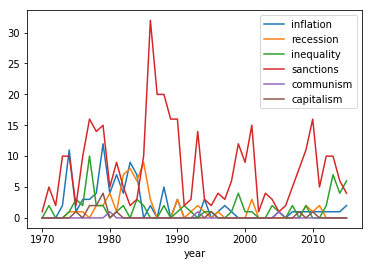

In [27]:
#Southern Africa Coordination Conference -SADCC member states
#Economic issues throughout the years
country = ['AGO', 'BWA', 'COD', 'LSO','MDG', 'MWI', 'MUS','MOZ', 'NAM', 'SYC', 'ZAF',
          'SWZ', 'TZA', 'ZMB', 'ZWE' ]
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


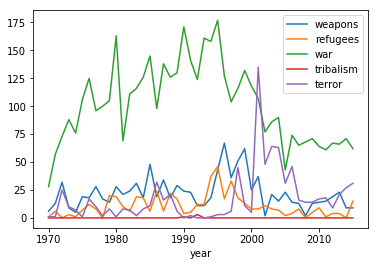

In [28]:
#Southern Africa Coordination Conference -SADCC member states
#Peace, stability and security issues
country = ['AGO', 'BWA', 'COD', 'LSO','MDG', 'MWI', 'MUS','MOZ', 'NAM', 'SYC', 'ZAF',
          'SWZ', 'TZA', 'ZMB', 'ZWE' ]
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


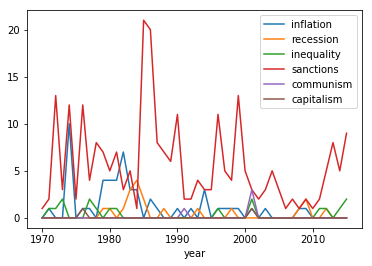

In [29]:
#Intergovernmental Authority on Development -IGAD memeber states
#Economic issues throughout the years
country = ['KEN', 'SDN','ETH', 'ERI', 'DJI','SOM', 'SSD', 'UGA']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


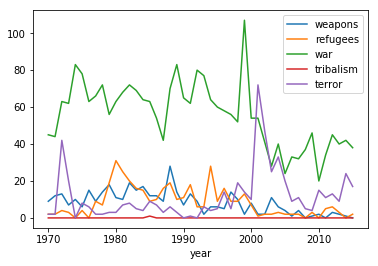

In [30]:
#Intergovernmental Authority on Development -IGAD memeber states

country = ['KEN', 'SDN','ETH', 'ERI', 'DJI','SOM', 'SSD', 'UGA']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()




/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


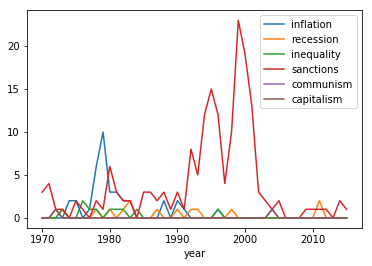

In [31]:
#The Arab Maghreb Union - AMU member states
#Economic issues throughout the years
country = ['DZA', 'LBY', 'MRT', 'MAR', 'TUN']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


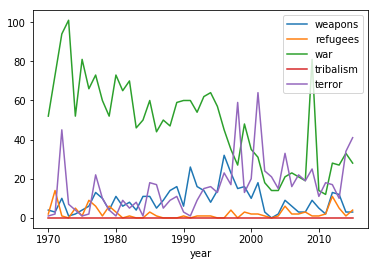

In [32]:
#The Arab Maghreb Union - AMU member states
#Peace, stability and security issues
country = ['DZA', 'LBY', 'MRT', 'MAR', 'TUN']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


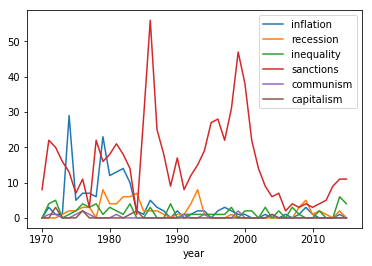

In [33]:
#Community of Sahel-Saharan States - CEN-SAD member states
#Economic issues throughout the years
country = ['BEN', 'BFA', 'CAF', 'TCD' 'COM', 'CIV', 'DJI', 'EGY', 'ERI', 'GMB', 
           'GHA', 'GNB', 'LBY', 'MLI','MRT', 'MAR', 'NER', 'NGA', 'SEN','SLE', 'SOM',
           'SDN', 'TGO', 'TUN']
topics =['inflation', 'recession','inequality', 'sanctions','communism', 'capitalism' ]
groupFreq(data, country, topics, 'year').plot()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


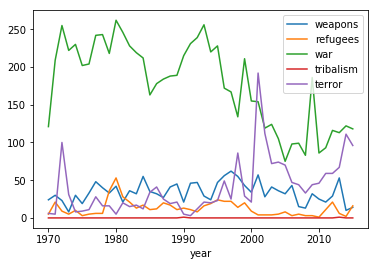

In [34]:
#Community of Sahel-Saharan States - CEN-SAD member states
#Peace, stability and security issues
country = ['BEN', 'BFA', 'CAF', 'TCD' 'COM', 'CIV', 'DJI', 'EGY', 'ERI', 'GMB', 
           'GHA', 'GNB', 'LBY', 'MLI','MRT', 'MAR', 'NER', 'NGA', 'SEN','SLE', 'SOM',
           'SDN', 'TGO', 'TUN']
topics =  ['weapons', 'refugees', 'war','tribalism', 'terror']
groupFreq(data, country, topics, 'year').plot()

In [35]:
#adds a 
country_name = []